# Análisis de estilo de vida y salud

Notebook en R para documentar los procedimientos de la **Entrega 1** del proyecto de Probabilidad y Estadística 2. Actualiza los campos en las secciones narrativas antes de exportar los resultados.


In [1]:
# Configuración de paquetes y tema global
todos_paquetes <- c(
  'tidyverse','janitor','skimr','gt','GGally','broom','gridExtra','viridis',
  'rmarkdown','IRkernel'
)

faltantes <- todos_paquetes[!sapply(todos_paquetes, requireNamespace, quietly = TRUE)]
if (length(faltantes) > 0) {
  install.packages(faltantes, dependencies = TRUE)
  if ('IRkernel' %in% faltantes) IRkernel::installspec()
}

invisible(lapply(todos_paquetes, library, character.only = TRUE))

theme_set(ggplot2::theme_minimal(base_size = 11))


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘janitor’




The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test





Attaching package: ‘gridExtra’




The following object is masked from ‘package:dplyr’:

    combine




Loading required package: viridisLite



In [2]:
# Cargar datos y preparar metadatos

ruta_datos <- "data/health_lifestyle_classification.csv"
stopifnot(file.exists(ruta_datos))

datos <- readr::read_csv(ruta_datos, show_col_types = FALSE) |> 
  janitor::clean_names()

categoricas <- c(
  "gender", "sleep_quality", "alcohol_consumption", "smoking_level",
  "mental_health_support", "education_level", "job_type", "occupation",
  "diet_type", "exercise_type", "device_usage", "healthcare_access",
  "insurance", "sunlight_exposure", "caffeine_intake", "family_history",
  "pet_owner", "target"
)

datos <- datos |> mutate(across(all_of(categoricas), as.factor))

ord_sleep <- c("Poor", "Fair", "Good", "Excellent")
ord_alcohol <- c("None", "Occasionally", "Regularly")
ord_smoking <- c("Non-smoker", "Light", "Moderate", "Heavy")
ord_healthcare <- c("Poor", "Moderate", "Good", "Excellent")
ord_device <- c("Low", "Moderate", "High")

ordenes <- list(
  sleep_quality = ord_sleep,
  alcohol_consumption = ord_alcohol,
  smoking_level = ord_smoking,
  healthcare_access = ord_healthcare,
  device_usage = ord_device
)

for (var in names(ordenes)) {
  if (var %in% names(datos)) {
    datos[[var]] <- factor(datos[[var]], levels = ordenes[[var]], ordered = TRUE)
  }
}

metadata <- tibble(
  variable = names(datos),
  tipo = sapply(datos, function(x) class(x)[1]),
  descripcion = NA_character_
)

glue::glue('Registros totales: {nrow(datos)} — Variables: {ncol(datos)}')

Registros totales: 100000 — Variables: 48

## 1. Marco metodológico y objetivo

Redacta aquí el contexto, procedencia de los datos y motivación del estudio. Ajusta el objetivo del análisis con base en tus preguntas de investigación.


In [3]:
tipos <- vapply(datos, function(x) class(x)[1], character(1))
marco_general <- tibble(
  indicador = c(
    'Registros',
    'Variables',
    'Variables cuantitativas',
    'Variables categóricas'
  ),
  valor = c(
    nrow(datos),
    ncol(datos),
    sum(tipos %in% c('numeric','integer','double')),
    sum(tipos %in% c('factor','ordered'))
  )
)

gt::gt(marco_general)


ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="cjayeddmxt" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#cjayeddmxt table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#cjayeddmxt thead, #cjayeddmxt tbody, #cjayeddmxt tfoot, #cjayeddmxt tr, #cjayeddmxt td, #cjayeddmxt th {
  border-style: none;
}

#cjayeddmxt p {
  margin: 0;
  padding: 0;
}

#cjayeddmxt .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

> **Objetivo sugerido:** Formular un objetivo general y al menos dos objetivos específicos que conecten los análisis descriptivos e inferenciales.

## 2. Análisis descriptivo de variables categóricas


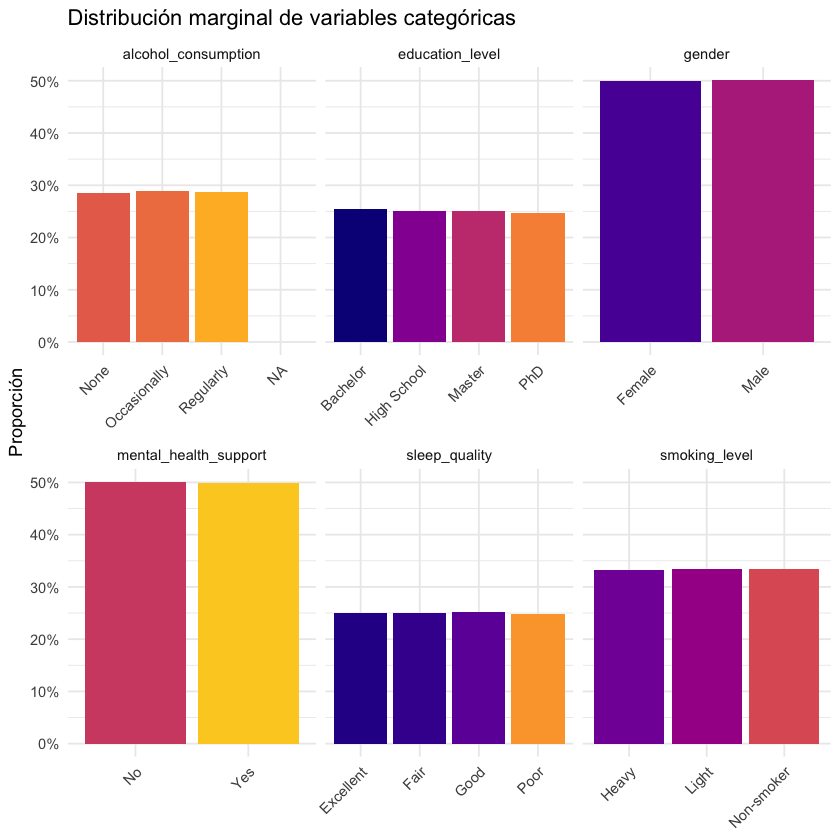

In [4]:
cat_vars <- metadata |> 
  filter(tipo %in% c("factor", "ordered")) |> 
  pull(variable)

frecuencias_cat <- datos |> 
  select(all_of(cat_vars)) |>
  mutate(across(everything(), as.character)) |> 
  pivot_longer(everything(), names_to = "variable", values_to = "categoria") |> 
  group_by(variable, categoria) |> 
  summarise(n = n(), .groups = "drop") |> 
  group_by(variable) |> 
  mutate(porcentaje = n / sum(n))

frecuencias_cat |> 
  filter(variable %in% head(cat_vars, 6)) |> 
  ggplot(aes(x = categoria, y = porcentaje, fill = categoria)) +
  geom_col() +
  scale_y_continuous(labels = scales::percent_format()) +
  scale_fill_viridis_d(option = "C", end = 0.9, guide = "none") +
  facet_wrap(~ variable, scales = "free_x") +
  labs(x = NULL, y = "Proporción", title = "Distribución marginal de variables categóricas") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [5]:
frecuencias_cat |> 
  filter(variable %in% head(cat_vars, 3)) |> 
  mutate(porcentaje = scales::percent(porcentaje)) |> 
  arrange(variable, desc(n)) |> 
  gt::gt(groupname_col = "variable")

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="lyyrwmiavb" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#lyyrwmiavb table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#lyyrwmiavb thead, #lyyrwmiavb tbody, #lyyrwmiavb tfoot, #lyyrwmiavb tr, #lyyrwmiavb td, #lyyrwmiavb th {
  border-style: none;
}

#lyyrwmiavb p {
  margin: 0;
  padding: 0;
}

#lyyrwmiavb .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

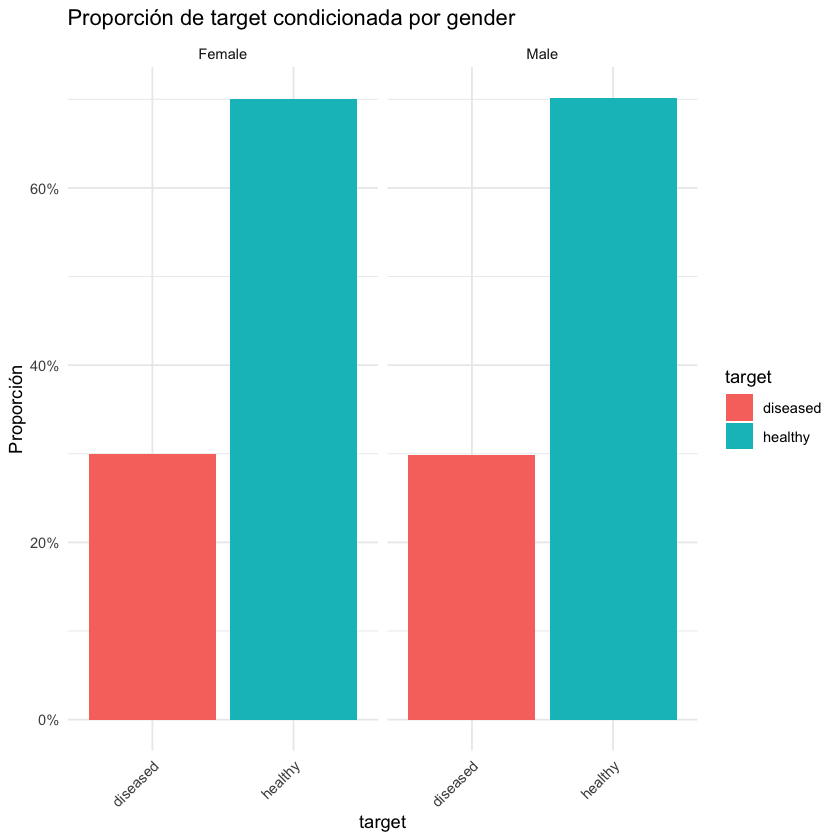

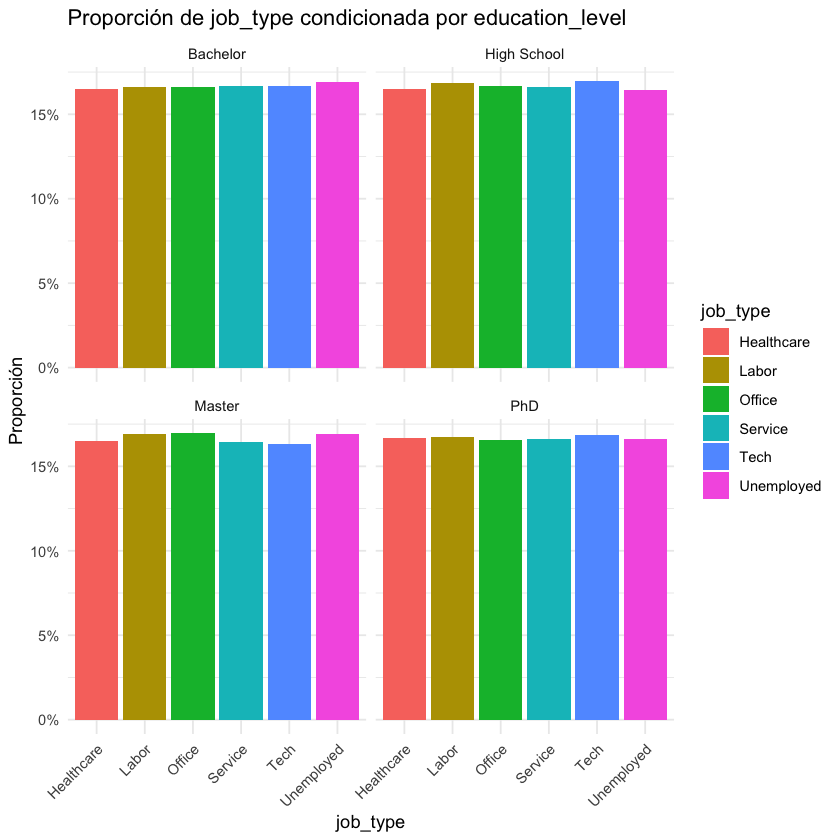

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="wuddnkkqxn" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#wuddnkkqxn table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#wuddnkkqxn thead, #wuddnkkqxn tbody, #wuddnkkqxn tfoot, #wuddnkkqxn tr, #wuddnkkqxn td, #wuddnkkqxn th {
  border-style: none;
}

#wuddnkkqxn p {
  margin: 0;
  padding: 0;
}

#wuddnkkqxn .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

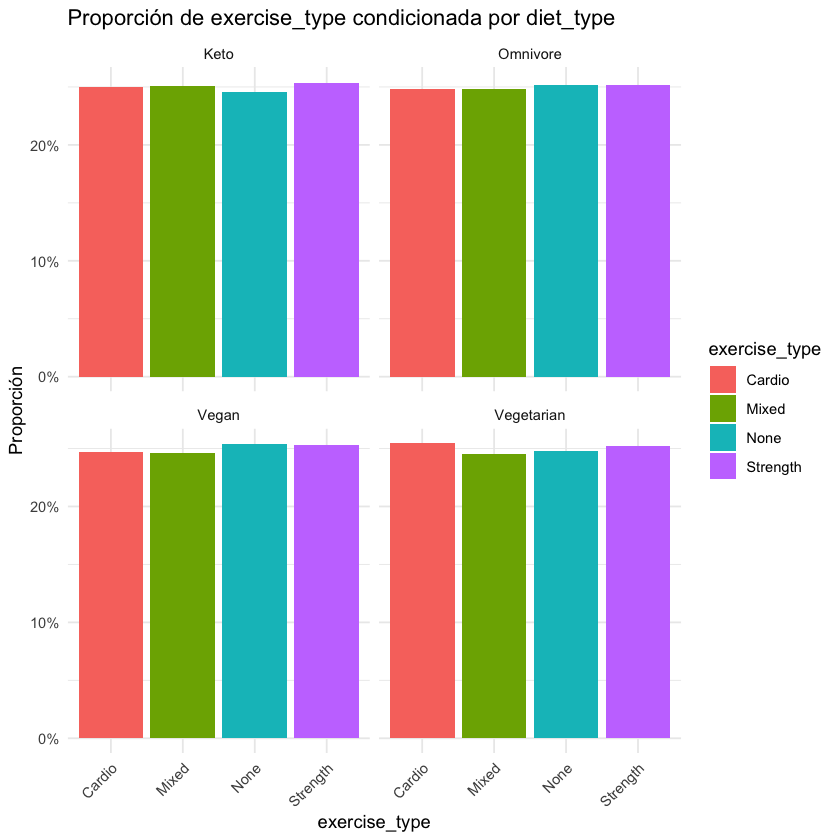

In [6]:
pares_cat <- tibble(
  variable_x = c("gender", "education_level", "diet_type"),
  variable_y = c("target", "job_type", "exercise_type")
)

coincidencias <- map2(pares_cat$variable_x, pares_cat$variable_y, ~ {
  x_sym <- rlang::sym(.x)
  y_sym <- rlang::sym(.y)
  tabla <- datos |> 
    count(!!x_sym, !!y_sym, name = "n") |> 
    group_by(!!x_sym) |> 
    mutate(prop = n / sum(n)) |> 
    ungroup()
  grafico <- tabla |> 
    ggplot(aes(x = !!y_sym, y = prop, fill = !!y_sym)) +
    geom_col() +
    scale_y_continuous(labels = scales::percent_format()) +
    labs(
      title = paste("Proporción de", .y, "condicionada por", .x),
      x = .y,
      y = "Proporción",
      fill = .y
    ) +
    facet_wrap(vars(!!x_sym)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  list(tabla = tabla, grafico = grafico)
})

walk(coincidencias, ~ print(.x$grafico))
coincidencias[[1]]$tabla |> gt::gt()

## 3. Análisis descriptivo de variables cuantitativas


In [7]:
cuant_vars <- metadata |> 
  filter(tipo %in% c("numeric", "integer")) |> 
  pull(variable)

skewness <- function(x) {
  x <- x[!is.na(x)]
  if (length(x) < 3 || sd(x) == 0) return(NA_real_)
  mean(((x - mean(x)) / sd(x))^3)
}

kurtosis_excess <- function(x) {
  x <- x[!is.na(x)]
  if (length(x) < 4 || sd(x) == 0) return(NA_real_)
  mean(((x - mean(x)) / sd(x))^4) - 3
}

resumen_cuant <- datos |> 
  select(all_of(cuant_vars)) |> 
  pivot_longer(everything(), names_to = "variable", values_to = "valor") |> 
  group_by(variable) |> 
  summarise(
    media = mean(valor, na.rm = TRUE),
    mediana = median(valor, na.rm = TRUE),
    desviacion = sd(valor, na.rm = TRUE),
    q1 = quantile(valor, 0.25, na.rm = TRUE),
    q3 = quantile(valor, 0.75, na.rm = TRUE),
    minimo = min(valor, na.rm = TRUE),
    maximo = max(valor, na.rm = TRUE),
    asimetria = skewness(valor),
    curtosis = kurtosis_excess(valor),
    faltantes = sum(is.na(valor)),
    .groups = "drop"
  )

resumen_cuant |> 
  mutate(across(where(is.numeric), round, 3)) |> 
  gt::gt()

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across(where(is.numeric), round, 3)`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="ivvhvrlicg" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#ivvhvrlicg table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#ivvhvrlicg thead, #ivvhvrlicg tbody, #ivvhvrlicg tfoot, #ivvhvrlicg tr, #ivvhvrlicg td, #ivvhvrlicg th {
  border-style: none;
}

#ivvhvrlicg p {
  margin: 0;
  padding: 0;
}

#ivvhvrlicg .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

Warning message:
“Removed 8329 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


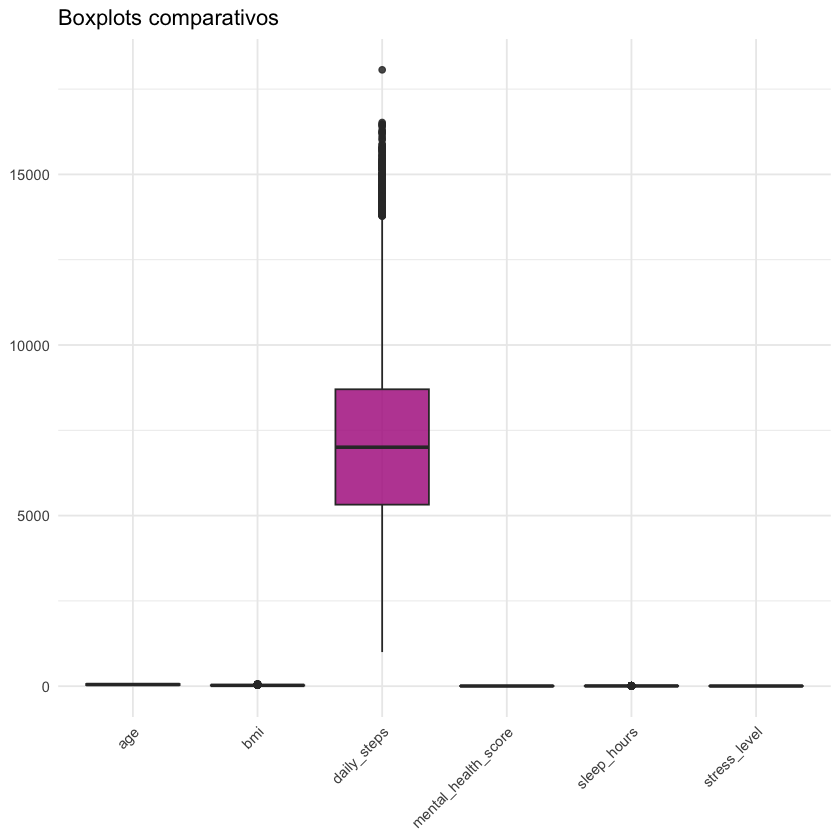

In [8]:
vars_para_hist <- c("age", "bmi", "sleep_hours", "daily_steps", "stress_level", "mental_health_score")

if (all(vars_para_hist %in% names(datos))) {
  datos |> 
    select(all_of(vars_para_hist)) |> 
    pivot_longer(everything(), names_to = "variable", values_to = "valor") |> 
    ggplot(aes(x = valor)) +
    geom_histogram(fill = "#2a9d8f", color = "white", bins = 30) +
    facet_wrap(~ variable, scales = "free") +
    labs(title = "Distribuciones univariadas de variables cuantitativas", x = NULL, y = "Frecuencia")

  datos |> 
    select(all_of(vars_para_hist)) |> 
    pivot_longer(everything(), names_to = "variable", values_to = "valor") |> 
    ggplot(aes(x = variable, y = valor, fill = variable)) +
    geom_boxplot(alpha = 0.85) +
    scale_fill_viridis_d(option = "C", guide = "none") +
    labs(x = NULL, y = NULL, title = "Boxplots comparativos") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="rzjaxebtdk" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#rzjaxebtdk table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#rzjaxebtdk thead, #rzjaxebtdk tbody, #rzjaxebtdk tfoot, #rzjaxebtdk tr, #rzjaxebtdk td, #rzjaxebtdk th {
  border-style: none;
}

#rzjaxebtdk p {
  margin: 0;
  padding: 0;
}

#rzjaxebtdk .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

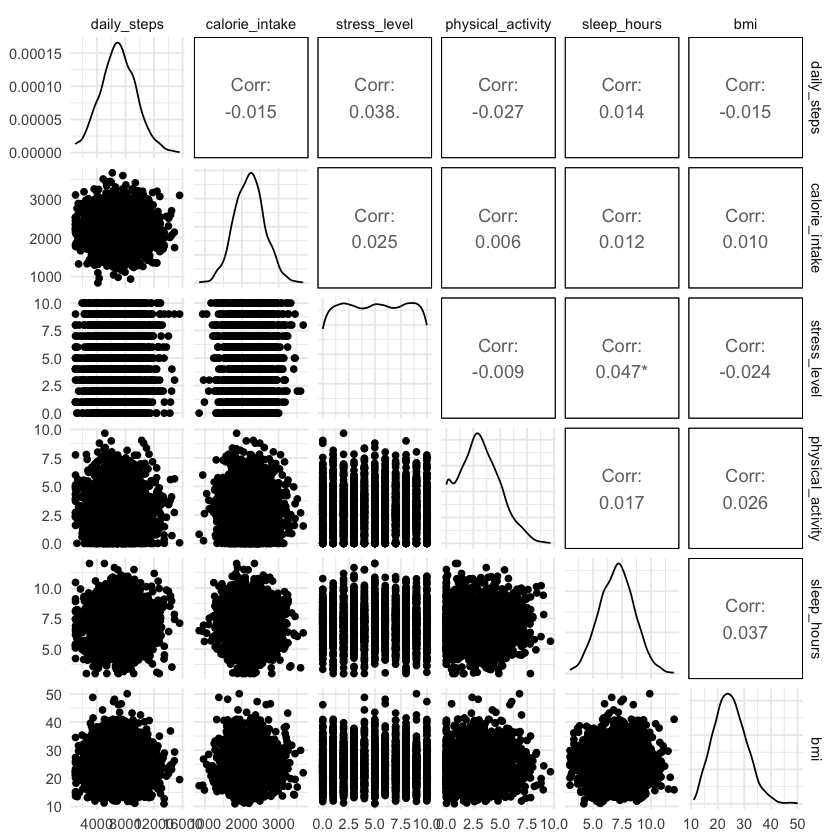

In [9]:
pares_cuant <- datos |> 
  select(daily_steps, calorie_intake, stress_level, physical_activity, sleep_hours, bmi)

cor_matrix <- round(cor(pares_cuant, use = "pairwise.complete.obs"), 2)

cor_matrix |> 
  as.data.frame() |> 
  tibble::rownames_to_column("variable") |> 
  gt::gt()

set.seed(123)
muestra_cuant <- datos |> 
  select(daily_steps, calorie_intake, stress_level, physical_activity, sleep_hours, bmi) |> 
  drop_na() |> 
  dplyr::slice_sample(n = 2000)

GGally::ggpairs(muestra_cuant)

> **Guía:** Describe las tendencias observadas e identifica posibles distribuciones teóricas para las variables cuantitativas clave.

## 4. Relación entre variables categóricas y cuantitativas


ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="iblzcevzaf" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#iblzcevzaf table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#iblzcevzaf thead, #iblzcevzaf tbody, #iblzcevzaf tfoot, #iblzcevzaf tr, #iblzcevzaf td, #iblzcevzaf th {
  border-style: none;
}

#iblzcevzaf p {
  margin: 0;
  padding: 0;
}

#iblzcevzaf .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

Warning message in geom_boxplot(alpha = 0.85, outlier_alpha = 0.25):
“Ignoring unknown parameters: `outlier_alpha`”


Warning message in geom_boxplot(alpha = 0.85, outlier_alpha = 0.25):
“Ignoring unknown parameters: `outlier_alpha`”


Warning message in geom_boxplot(alpha = 0.85, outlier_alpha = 0.25):
“Ignoring unknown parameters: `outlier_alpha`”


Warning message in geom_boxplot(alpha = 0.85, outlier_alpha = 0.25):
“Ignoring unknown parameters: `outlier_alpha`”


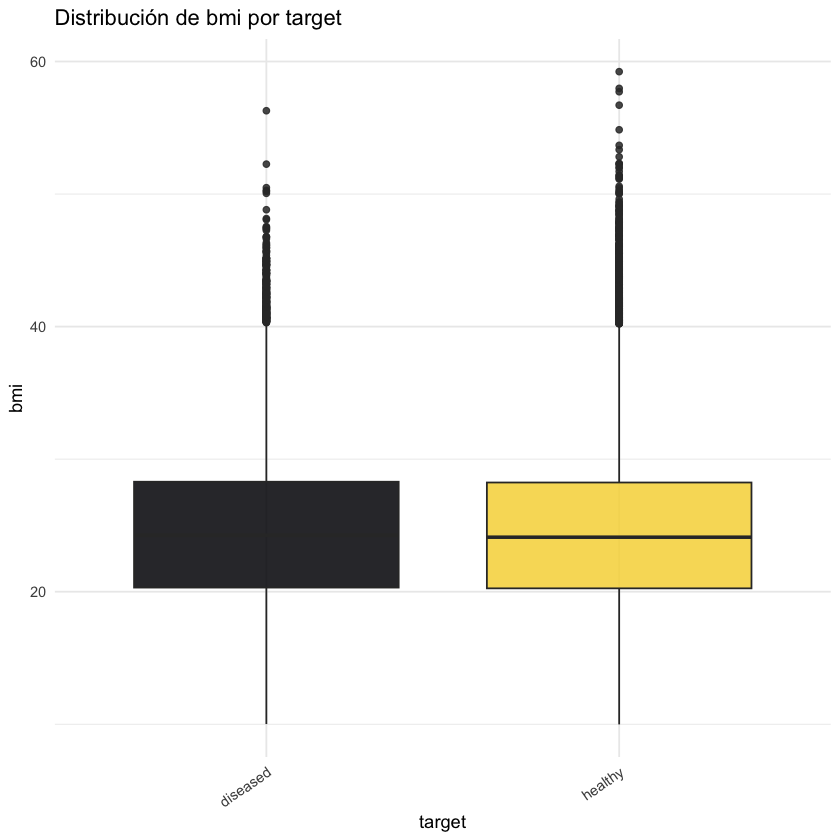

Warning message:
“Removed 8329 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


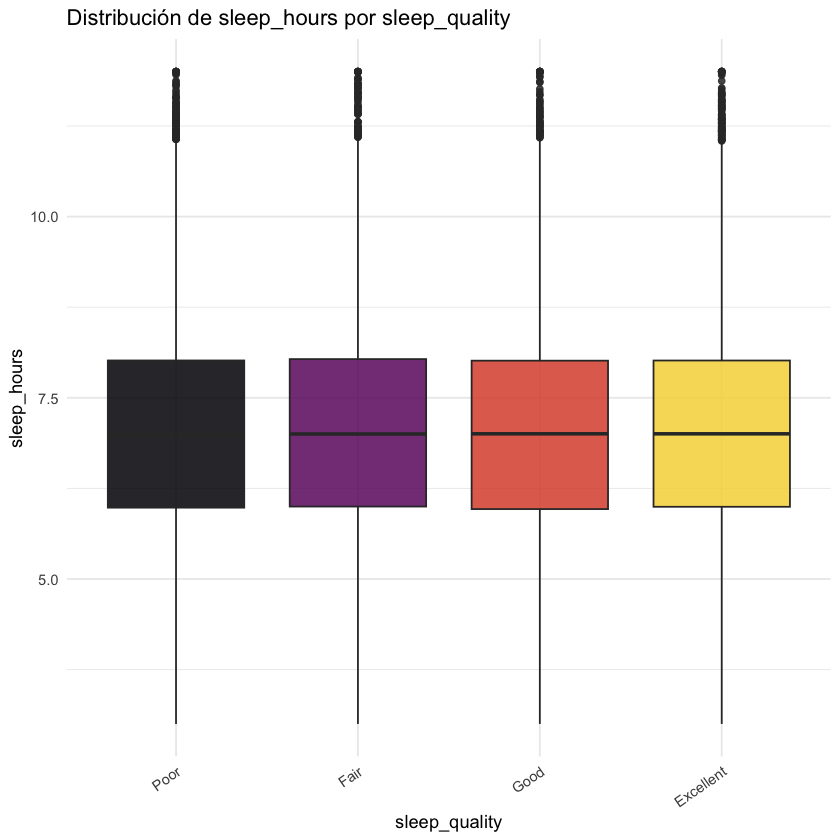

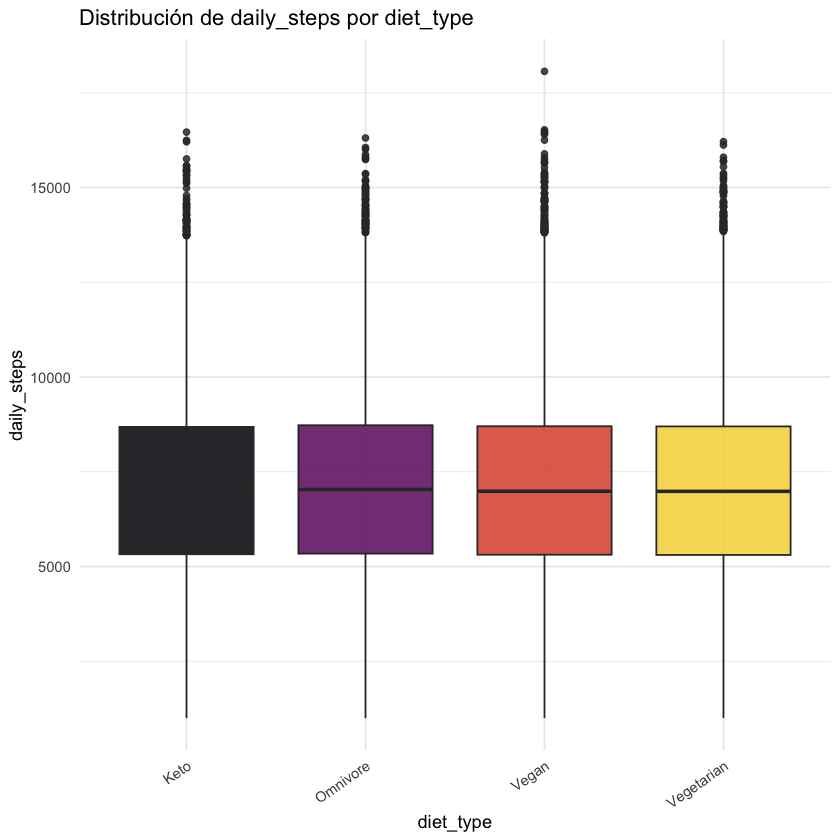

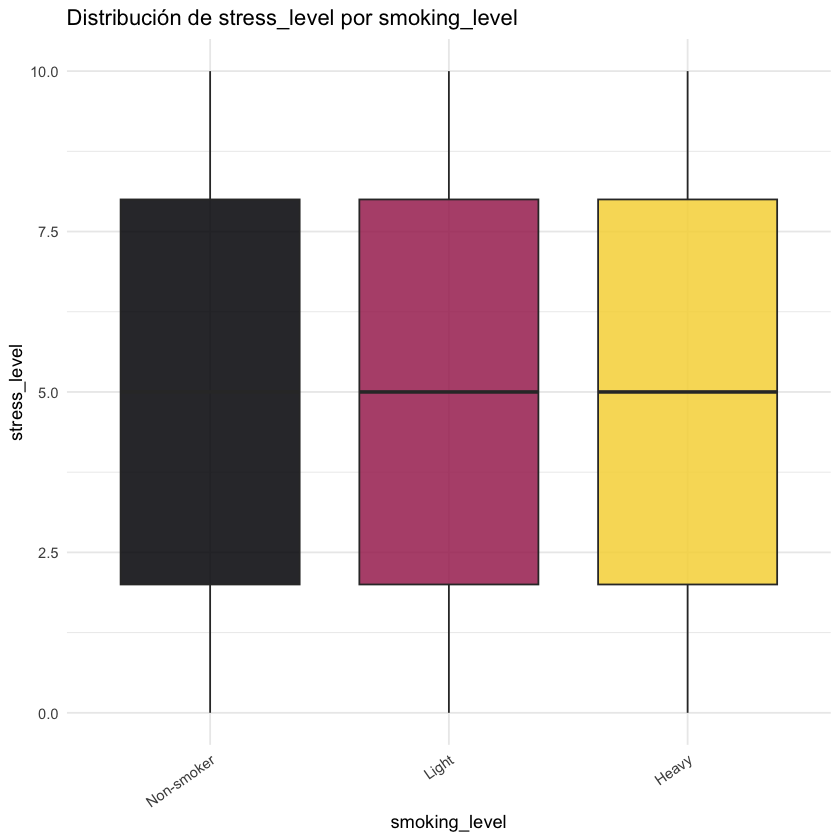

In [10]:
ejemplos_cat <- c("target", "sleep_quality", "diet_type", "smoking_level")
cuant_vars_interes <- c("bmi", "sleep_hours", "daily_steps", "stress_level")

resumen_cat_cuant <- purrr::map_dfr(ejemplos_cat, function(cat_var) {
  cat_sym <- rlang::sym(cat_var)
  datos |> 
    select(!!cat_sym, all_of(cuant_vars_interes)) |> 
    pivot_longer(cols = all_of(cuant_vars_interes), names_to = "variable_cuant", values_to = "valor") |> 
    group_by(grupo = !!cat_sym, variable_cuant) |> 
    summarise(
      n = n(),
      media = mean(valor, na.rm = TRUE),
      mediana = median(valor, na.rm = TRUE),
      sd = sd(valor, na.rm = TRUE),
      q1 = quantile(valor, 0.25, na.rm = TRUE),
      q3 = quantile(valor, 0.75, na.rm = TRUE),
      .groups = "drop"
    ) |> 
    mutate(grupo = as.character(grupo)) |> 
    mutate(variable_categorica = cat_var)
})

resumen_cat_cuant |> 
  mutate(across(where(is.numeric), round, 3)) |> 
  gt::gt(groupname_col = "variable_categorica")

pares_cat_cuant <- tibble::tribble(
  ~cat, ~cuant,
  "target", "bmi",
  "sleep_quality", "sleep_hours",
  "diet_type", "daily_steps",
  "smoking_level", "stress_level"
)

plot_list <- purrr::map2(pares_cat_cuant$cat, pares_cat_cuant$cuant, function(cat_var, cuant_var) {
  cat_sym <- rlang::sym(cat_var)
  cuant_sym <- rlang::sym(cuant_var)
  datos |> 
    ggplot(aes(x = !!cat_sym, y = !!cuant_sym, fill = !!cat_sym)) +
    geom_boxplot(alpha = 0.85, outlier_alpha = 0.25) +
    scale_fill_viridis_d(option = "B", end = 0.9, guide = "none") +
    labs(
      title = paste("Distribución de", cuant_var, "por", cat_var),
      x = cat_var,
      y = cuant_var
    ) +
    theme(axis.text.x = element_text(angle = 35, hjust = 1))
})

walk(plot_list, print)

## 5. Pruebas de hipótesis


In [11]:
prueba_media <- t.test(datos$sleep_hours, mu = 7)
resultado_media <- broom::tidy(prueba_media)

resultado_media |> 
  mutate(across(where(is.numeric), round, 4)) |> 
  gt::gt()

conteo_target <- datos |> 
  summarise(
    exito = sum(target == "healthy", na.rm = TRUE),
    total = n()
  )

prueba_prop <- prop.test(x = conteo_target$exito, n = conteo_target$total, p = 0.70, alternative = "two.sided")
resultado_prop <- broom::tidy(prueba_prop)

resultado_prop |> 
  mutate(across(where(is.numeric), round, 4)) |> 
  gt::gt()

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="qvhrykttiz" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#qvhrykttiz table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#qvhrykttiz thead, #qvhrykttiz tbody, #qvhrykttiz tfoot, #qvhrykttiz tr, #qvhrykttiz td, #qvhrykttiz th {
  border-style: none;
}

#qvhrykttiz p {
  margin: 0;
  padding: 0;
}

#qvhrykttiz .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="ejtdrctkuh" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#ejtdrctkuh table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#ejtdrctkuh thead, #ejtdrctkuh tbody, #ejtdrctkuh tfoot, #ejtdrctkuh tr, #ejtdrctkuh td, #ejtdrctkuh th {
  border-style: none;
}

#ejtdrctkuh p {
  margin: 0;
  padding: 0;
}

#ejtdrctkuh .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

Recuerda especificar hipótesis nula/alternativa, supuestos, decisión con respecto a H₀ y conclusiones interpretadas en el contexto del estudio.

## 6. Anexo: Diccionario y control de calidad


In [12]:
diccionario <- metadata |> 
  mutate(
    tipo_variable = case_when(
      tipo %in% c("numeric", "integer") ~ "Cuantitativa",
      tipo %in% c("factor", "ordered") ~ "Categórica",
      TRUE ~ tipo
    ),
    valores_unicos = purrr::map_int(datos[variable], ~ dplyr::n_distinct(.x, na.rm = TRUE))
  ) |> 
  select(variable, tipo_variable, valores_unicos, descripcion)

diccionario |> 
  gt::gt() |> 
  gt::tab_spanner(label = "Completar las descripciones antes de la entrega", columns = everything())

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="swcswjtxmq" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#swcswjtxmq table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#swcswjtxmq thead, #swcswjtxmq tbody, #swcswjtxmq tfoot, #swcswjtxmq tr, #swcswjtxmq td, #swcswjtxmq th {
  border-style: none;
}

#swcswjtxmq p {
  margin: 0;
  padding: 0;
}

#swcswjtxmq .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

In [13]:
faltantes <- datos |> 
  summarise(across(everything(), ~ sum(is.na(.)))) |> 
  pivot_longer(everything(), names_to = "variable", values_to = "faltantes") |> 
  mutate(pct = faltantes / nrow(datos)) |> 
  arrange(desc(faltantes))

faltantes |> 
  filter(faltantes > 0) |> 
  mutate(pct = scales::percent(pct)) |> 
  slice_head(n = 15) |> 
  gt::gt()

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 1, 0, 10

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .       

<div id="bcffrienru" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#bcffrienru table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#bcffrienru thead, #bcffrienru tbody, #bcffrienru tfoot, #bcffrienru tr, #bcffrienru td, #bcffrienru th {
  border-style: none;
}

#bcffrienru p {
  margin: 0;
  padding: 0;
}

#bcffrienru .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 16px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  b

> **Checklist final:** documenta conclusiones, guarda las figuras relevantes en `figs/` y exporta el reporte PDF dentro de `reports/` siguiendo el formato solicitado.
